# Comparison of Salmon-based PolII CRAC quantification with figure from Tomek


<img src="tomasz.png"></img>

**Samples**
- BY4741 + 128 kb neochromosome (+ Rpo31/Rpc160)
- BY4741 + pRS415 (+ Rpo31/Rpc160)
- BY4741 (- Rpo31/Rpc160)

Rpo31/Rpc160 is largest catalytic subunit of RNAPIII. HTP-tagged for CRAC. 

In [1]:
.libPaths("~/R/x86_64-redhat-linux-gnu-library/3.2/")
# config opts and libraries
options(repr.plot.width = 6)
options(repr.plot.height = 5)
options(jupyter.plot_mimetypes = 'image/png')
devtools::source_url("https://raw.githubusercontent.com/scalefreegan/R-tools/master/defaultRlibs.R")
library(ggExtra)

SHA-1 hash of file is 22fb06d671e2b067831995cd09e786560ab301f3

Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, coln

In [2]:
GENOME = "/g/steinmetz/project/IESY/genomes/"
# load ncRNA annotations
load("/g/steinmetz/project/IESY/trna/data/ncRNA_annotations.rda")

RESULTS = "/g/steinmetz/project/IESY/trna/results/polIIIcrac"
# load neo2wt tRNA annotations
mf = "/g/steinmetz/project/IESY/genomes/annotations/trna_neo2wt_match.rds"
chr18_wt_match <- readRDS(mf)
# load tRNA sim
sf = "/g/steinmetz/project/IESY/trna/allncrnas_stringdistmatrix.rda"
load(sf)
allstringdistmatrix = allstringdistmatrix %>% mutate(x = gsub("^WT\\.","",x),x = gsub("^SYN\\.","",x),
                                    y = gsub("^WT\\.","",y),y = gsub("^SYN\\.","",y))
f2 = "/g/steinmetz/project/IESY/genomes/annotations/trna_neo2wt_NOmatch.rds"
seq_nomatch <- readRDS(f2)

sample2ezname = function(x) {
    o = x
    o[x == "S1"] = "BY4741-neg"
    o[x == "S2"] = "BY4741"
    o[x == "S3"] = "BY4741+neo"
    return(o)
}

sf = file.path(RESULTS,"results.rds")
results <- readRDS(sf)

In [3]:
#leucca = bind_rows(get_bootstraps(so,"WT.chr01.tRNA3-LeuCAA"),get_bootstraps(so,"WT.chr07.tRNA24-LeuCAA"))

In [4]:
# pair WT-neo chr samples using neo2wt annotations
trna_pair_quant = chr18_wt_match %>% select(note,Name.x,Name.y,aa,anticodon) %>% rowwise() %>% do({
    thisrow = .
    mrows.x = results %>% filter(thisrow$Name.x == Name)
    mrows.y = results %>% filter(thisrow$Name.y == Name)
    mrows = merge(mrows.x, mrows.y, by = "sample")
    x = filter(allstringdistmatrix, x==thisrow$Name.x, type=="whole")
    x.y = filter(x, x==thisrow$Name.x, y==thisrow$Name.y, type=="whole")
    lt = filter(x, norm.value <= x.y$norm.value)
    sim.count = dim(lt)[1]
    o = data.frame(Name.x = thisrow$Name.x,
                   Name.y = thisrow$Name.y,
                   note = thisrow$note,
                   aa = thisrow$aa,
                   anticodon = thisrow$anticodon,
                   TPM.x = mrows$TPM.x,
                   NumReads.x = mrows$NumReads.x,
                   TPM.y = mrows$TPM.y,
                   NumReads.y = mrows$NumReads.y,
                   sample = mrows$sample,
                   sim.count,
                   stringsAsFactors = F
                  )
    return(o)
    }) %>% mutate(ezsample = sample2ezname(sample)) %>%
    mutate(intron = factor(note %in% seq_nomatch$note))

# Figure 1: Class distribution of mapped reads

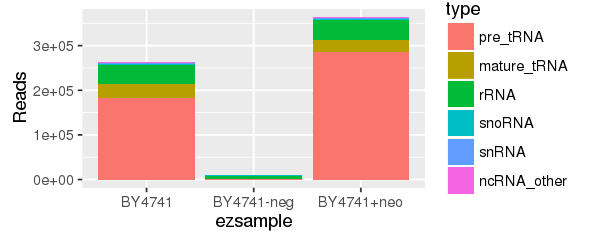

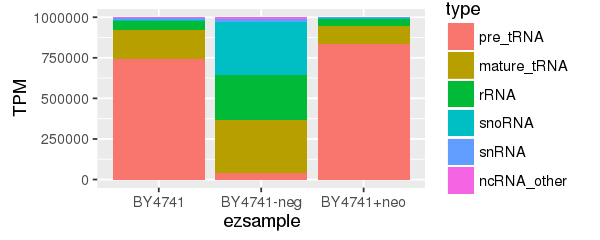

In [5]:
options(repr.plot.width = 5)
options(repr.plot.height = 2)
results$type = factor(results$type, levels = (c(
"pre_tRNA",
"mature_tRNA",
"rRNA",
"snoRNA",
"snRNA",
"ncRNA_other")))
p1 <- ggplot(results %>% group_by(type, ezsample) %>% summarise(sum=sum(NumReads))) + 
geom_bar(aes(y = sum, x = ezsample, 
    fill = type), stat = "identity") +
    ylab("Reads")
p1

p1.2 <- ggplot(results %>% group_by(type, ezsample) %>% summarise(sum=sum(TPM))) + 
geom_bar(aes(y = sum, x = ezsample, 
    fill = type), stat = "identity") +
    ylab("TPM")
p1.2


In [6]:
# computed as fraction
summaryresults = results %>% group_by(type, ezsample) %>% summarise(TPM=sum(TPM))
summaryresults.groupsums = summaryresults %>% group_by(ezsample) %>% summarise(sum = sum(TPM))
summaryresults = summaryresults %>% rowwise() %>% do({
    thisrow = .
    frac = thisrow$TPM/filter(summaryresults.groupsums, ezsample == thisrow$ezsample)$sum
    o = data.frame(thisrow, frac = frac)
    return(o)
})
summaryresults %>% filter(type %in% c("pre_tRNA","mature_tRNA"), grepl("BY",ezsample))

Warning message:
In bind_rows_(x, .id): Unequal factor levels: coercing to character

,type,ezsample,TPM,frac
1,pre_tRNA,BY4741,741436.9,0.7414369
2,pre_tRNA,BY4741-neg,37941.9,0.03794189
3,pre_tRNA,BY4741+neo,832726.7,0.8327266
4,mature_tRNA,BY4741,181412.5,0.1814125
5,mature_tRNA,BY4741-neg,331317.4,0.3313173
6,mature_tRNA,BY4741+neo,115805.6,0.1158055


# Figure 2: Relative expression all pre-tRNAs

Using origin, ezsample as id variables
Using origin, ezsample as id variables


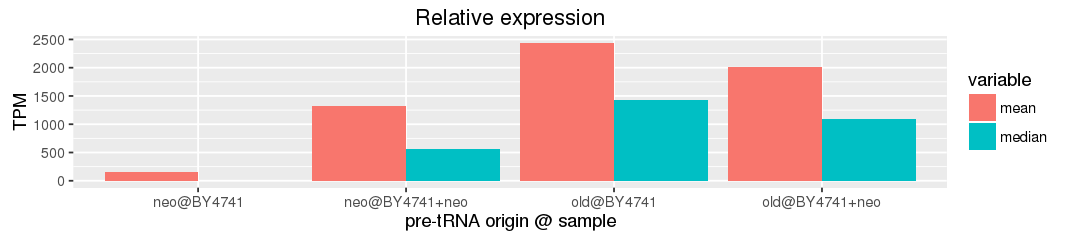

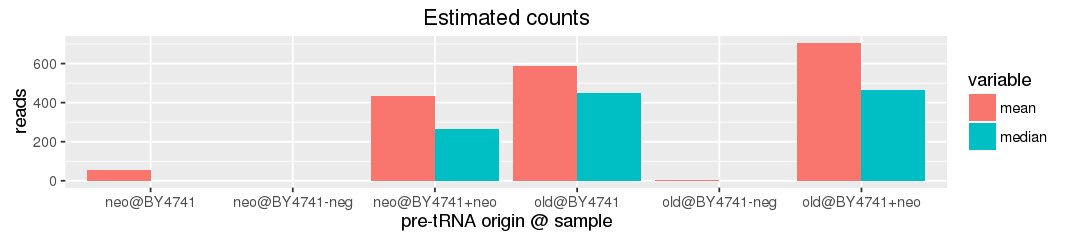

In [7]:
options(repr.plot.width = 9)
options(repr.plot.height = 2)
results.mm = results  %>% filter(type=="pre_tRNA", !grepl("-neg",ezsample)) %>% 
    group_by(origin,ezsample) %>% summarise(mean = mean(TPM), median = median(TPM)) %>% ungroup() %>%
    mutate(origin = ifelse(origin=="SYN","neo","old")) %>% melt() %>% mutate(name = paste(origin,ezsample,sep="@"))
p2 <- ggplot(results.mm) + geom_bar(aes(x=name,y=value+1,fill=variable),stat="identity",position = "dodge") +
    xlab("pre-tRNA origin @ sample") + ylab("TPM") + 
    ggtitle("Relative expression")
p2

results.mm2 = results %>% filter(type=="pre_tRNA", grepl("BY",ezsample)) %>% 
    group_by(origin,ezsample) %>% summarise(mean = mean(NumReads), median = median(NumReads)) %>% ungroup() %>%
    mutate(origin = ifelse(origin=="SYN","neo","old")) %>% melt() %>% mutate(name = paste(origin,ezsample,sep="@"))
p2.2 <- ggplot(results.mm2) + geom_bar(aes(x=name,y=value+1,fill=variable),stat="identity",position = "dodge") +
    xlab("pre-tRNA origin @ sample") + ylab("reads") + 
    ggtitle("Estimated counts")
p2.2

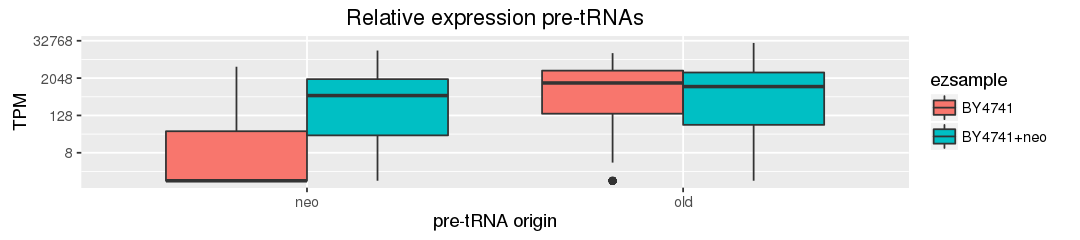

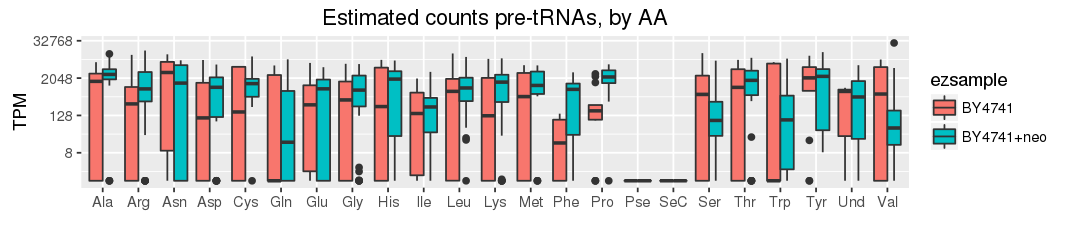

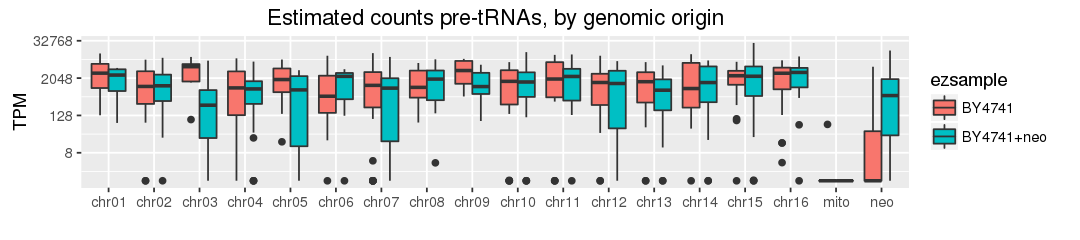

In [8]:
r2p = results %>% filter(type=="pre_tRNA", !grepl("-neg",ezsample)) %>% mutate(origin = ifelse(origin=="SYN","neo","old"))
r2pm = results %>% filter(type=="mature_tRNA", !grepl("-neg",ezsample)) %>% mutate(origin = ifelse(origin=="SYN","neo","old"))

p2.3 <- ggplot(r2p) +
    geom_boxplot(aes(x=origin, y = TPM+1, fill = ezsample)) + scale_y_continuous(trans="log2") +
    xlab("pre-tRNA origin") + ylab("TPM") + 
    ggtitle("Relative expression pre-tRNAs")
p2.3
p2.4 <- ggplot(r2p) +
    geom_boxplot(aes(x=AA, y = TPM+1, fill = ezsample)) + scale_y_continuous(trans="log2") +
    xlab("") + ylab("TPM") + 
    ggtitle("Estimated counts pre-tRNAs, by AA")
p2.4
p2.4 <- ggplot(r2p) +
    geom_boxplot(aes(x=ezseqid, y = TPM+1, fill = ezsample)) + scale_y_continuous(trans="log2") +
    xlab("") + ylab("TPM") + 
    ggtitle("Estimated counts pre-tRNAs, by genomic origin")
p2.4


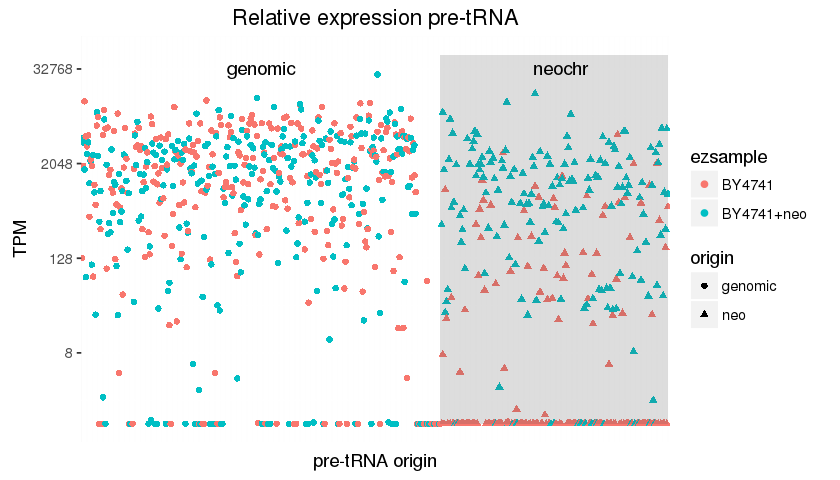

In [10]:
options(repr.plot.width = 7)
options(repr.plot.height = 4)
r2p2 = results %>% filter(type=="pre_tRNA", !grepl("-neg",ezsample)) %>% 
    mutate(origin = ifelse(origin=="SYN","neo","genomic"))
levels(r2p2$origin) = c("neo","genomic")
r2p2 = r2p2 %>% arrange(origin)
p2.5 <- ggplot(r2p2, aes(x=Name, y = TPM + 1, color = ezsample, shape = origin)) + 
    geom_point() + scale_y_continuous(trans="log2") +
    xlab("pre-tRNA origin") + ylab("TPM") + 
    ggtitle("Relative expression pre-tRNA") + theme(axis.ticks.x=element_blank(),axis.text.x=element_blank()) +
    annotate("rect", xmin = sum(r2p2$origin=="genomic")/2, xmax = dim(r2p2)[1]/2, ymin = 1, ymax = 50000, alpha = .2) +
    annotate("text", x = sum(r2p2$origin=="genomic")/4, y = 32768, label = "genomic") +
    annotate("text", x = sum(r2p2$origin=="genomic")/1.5, y = 32768, label = "neochr")
p2.5